# notebook for named entity recognition, URLs, quotes

In [1]:
import re
import spacy
import datetime
import numpy as np
import pandas as pd
from urllib.request import urlopen
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
from fuzzywuzzy import fuzz

In [ ]:
moza = pd.read_csv('./data/search_mozambique_20190315_to_20190414_nwsppr.csv')
nlp = spacy.load("en_core_web_sm")

### URLs, text length, number of words

In [6]:
len(moza)

2070

In [7]:
moza['date'] = moza.SQLDATE.apply(lambda date: datetime.datetime.strptime(str(date), '%Y%m%d').date())

In [8]:
def get_page(url):
    try:
        page = re.search(r'https?:\/+([\w\W]+?)\/', url)
        return page.group(1)
    except AttributeError: print(url)

In [9]:
moza['url'] = moza.SOURCEURL.apply(lambda url: get_page(url))

In [10]:
moza['article_stripped'] = moza.article.apply(lambda art: re.sub(r'(\xa0)|(\n)| +', ' ', art))

In [11]:
moza['textlength'] = moza.article_stripped.apply(lambda x: len(x))

In [12]:
moza['words'] = moza.article_stripped.apply(lambda x: len(x.split()))

### drop duplicates after stripping articles

In [59]:
# only drop if no publish time!!
mozaNODUP = moza.drop_duplicates('article_stripped')

In [60]:
len(mozaNODUP)

1997

### some numbers

In [12]:
round(mozaNODUP.textlength.mean())

3580.0

In [13]:
round(mozaNODUP.words.mean())

575.0

In [14]:
round(mozaNODUP.words.median())

487.0

### extract quotes with regexes

In [25]:
def count_quotes(article):
    quotes = []
    text_length=len(article.split(" "))
    quoted=re.findall(r'("[\W\w]+?"|„[\W\w]+?“|»[\W\w]+?«|«[\W\w]+?»)',article)
    length_quoted=0
    for item in quoted:
        length=len(item.split(" ")) 
        if length > 3:
            print(item)
            length_quoted+=length
            quotes.append(item)
    quoted_ratio=length_quoted/text_length
    return quoted_ratio, quotes

In [26]:
mozaNODUP['quoted_ratio'], mozaNODUP['quotes'] = zip(*mozaNODUP.article_stripped.apply(lambda x: count_quotes(x)))

"We just sleep on the floor in the tents,"
"It's a camp, so the situation is dire. You just find a small space in the tent with your family and make it home."
"The floods came very quickly and we had no time to rescue anything, most of my property went with the floods,"
"What was important was to save lives."
"Although we have food, we have no cooking utensils to prepare the food because everything was lost,"
"We cannot go back soon because the water has not receded and so the house has been destroyed. So we will hang around the camp until the situation normalises. We have no other choice."
"We have huge gaps in terms of resources such as food and non-food items,"
"What we desperately need right now is food, tents, medication and mosquito nets."
"We are airlifting supplies to Makhanga where about 2,000 households have been affected,"
"Due to the flooding, the area is only accessible by boat or by air. We intend to airlift 600 bags of rice and other non-food items to Makhanga."
"Most of

"We did the lab tests and can confirm that these five people tested positive for cholera,"
"It will spread. When you have one case, you have to expect more cases in the community."
"We were expecting cholera cases and we were prepared for this. We have put all the measures in place to try to mitigate the spread of cholera as much as we can,"
"great visibility and acceptance"
"Frelimo is visible throughout the country, and also in Nampula province. You can't assess the results of future elections based on the municipal elections held last year"
"Those elections were in municipalities, and not in all districts"
"We are working and we are sure that in the presidential, parliamentary and provincial elections we are indeed going to win. You can see Frelimo in any part of this province"
"There's a calm atmosphere and one of acceptance of our party's message. There's great enthusiasm among our militants in all districts, and this leads us to say we have the conditions to work to guarantee the

"there is no food"
"We need to work. We need to get to our farms, we need to rebuild ourselves,"
"just a cup of (vitamin-fortified) soya per family. It's way too little,"
"We really have nothing to eat, we have received almost nothing in aid,"
"We must not let these people suffer a second disaster through a serious disease outbreak or inability to access essential health services. They have suffered enough,"
"We must not let these people suffer a second disaster through a serious disease outbreak or inability to access essential health services.    "
" Dr. Djamila Cabral, the WHO Representative in Mozambique, told reporters in Geneva. She said people in camps were living in "
" and that about 55 health centers had been severely damaged.  Aid continued to arrive, including much-needed air support. The World Food Program received $280 000 from the European Union to support the deployment of a UN Humanitarian Air Service helicopter that will deliver assistance to the two worst-hit distric

/home/iz/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


### article count over time

In [15]:
rng = pd.date_range('03-15-2019', '04-14-2019')
dates = rng.to_pydatetime()
idx = [date.strftime('%Y-%m-%d') for date in dates]

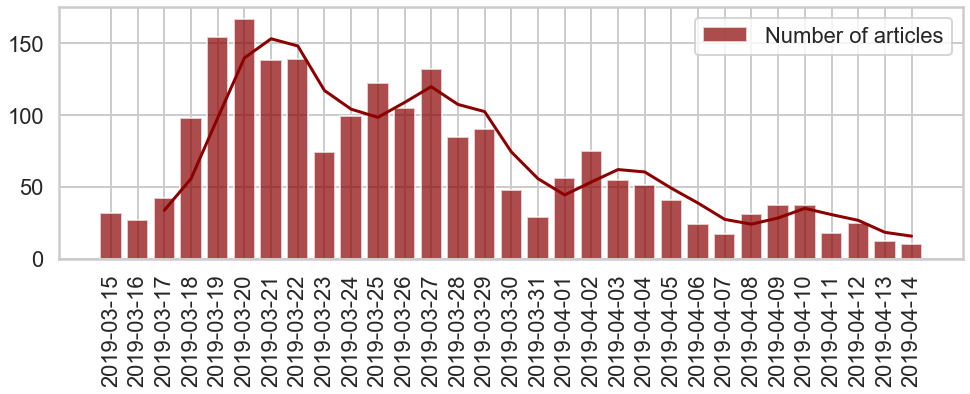

In [164]:
sns.set(style='whitegrid')
sns.set_context('poster')
fig, ax = plt.subplots(figsize=(14,6))
article_count = moza.groupby('date').size()
plt.bar(idx, article_count, label='Number of articles', color='darkred', alpha=.7)
plt.plot(idx, article_count.rolling(3).mean(), color='darkred')
plt.xticks(idx, rotation='vertical')
plt.legend()
plt.tight_layout()
plt.savefig('../plots/article_count_moza_nwsppr_PosterStyle.png')
plt.show()        

### quoted ratio

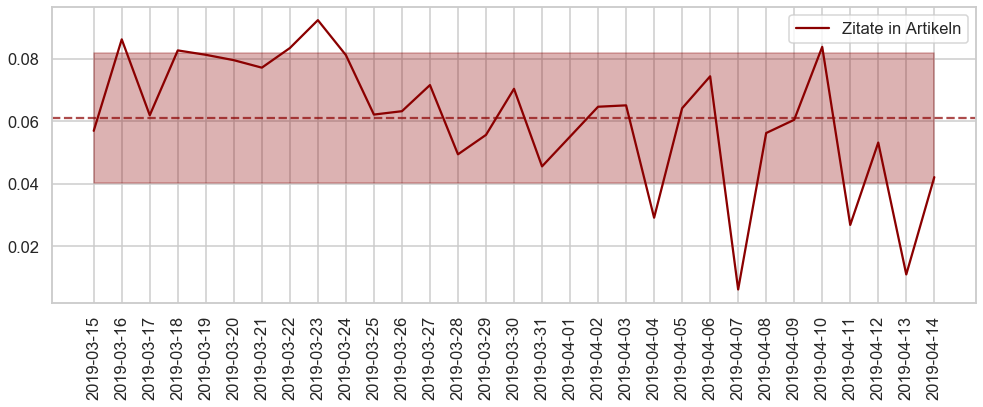

In [45]:
sns.set(style='whitegrid')
sns.set_context('talk')
fig, ax = plt.subplots(figsize=(14,6))
quoted = mozaNODUP.groupby('date').quoted_ratio.mean()
plt.plot(idx, quoted, label='Zitate in Artikeln', color='darkred')
plt.axhline(np.mean(quoted), xmin= 0, xmax=30, ls='--', color='darkred', alpha=.7)
plt.fill_between(range(len(idx)), np.mean(quoted)+np.std(quoted),
                      np.mean(quoted)-np.std(quoted), color='darkred', alpha=.3)
plt.xticks(idx, rotation='vertical')
plt.legend()
plt.tight_layout()
plt.savefig('../plots/quoted_moza_nwsppr_TalkStyle.png')
plt.show()

### article length by date

In [12]:
daily_means = moza.groupby('date').words.mean().round()

In [13]:
daily_medians = moza.groupby('date').words.median().round()

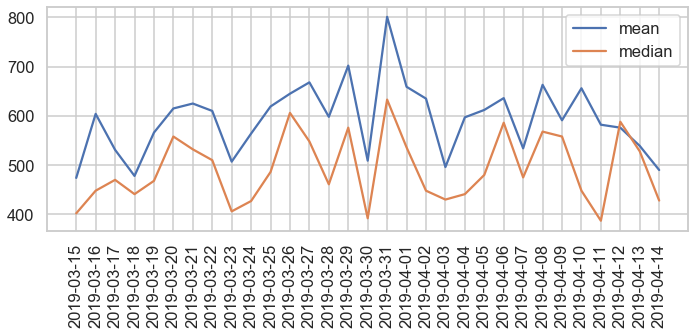

In [14]:
fig, ax = plt.subplots(figsize=(10,5))
plt.plot(idx, daily_means, label='mean')
plt.plot(idx, daily_medians, label='median')
plt.xticks(idx, rotation='vertical')
plt.legend()
plt.tight_layout()
plt.savefig('./plots/article_length_by_day_newsppr_TalkStyle.png')
plt.show()        

### named entity recognition

In [28]:
def get_nes(text):
    doc = nlp(text)
    ents = [(e.text, e.start_char, e.end_char, e.label_) for e in doc.ents]
    return ents

In [29]:
moza['nes'] = mozaNODUP.article_stripped.apply(lambda art: get_nes(art))

In [30]:
def count_certain_nes(nes, tags):
    nes_ = [ne[0] for ne in nes if ne[3] in tags and len(ne[0].split()) < 5]
    counted = Counter(nes_).most_common()
    count_dict = dict(zip([x[0] for x in counted], [x[1] for x in counted]))
    return count_dict

In [31]:
moza['NE_persons'] = mozaNODUP.nes.apply(lambda x: count_certain_nes(x, ['PERSON']))
moza['NE_places'] = mozaNODUP.nes.apply(lambda x: count_certain_nes(x, ['GPE', 'LOC']))
moza['NE_norps'] = mozaNODUP.nes.apply(lambda x: count_certain_nes(x, ['NORP']))
moza['NE_orgs'] = mozaNODUP.nes.apply(lambda x: count_certain_nes(x, ['ORG']))
moza['NE_events'] = mozaNODUP.nes.apply(lambda x: count_certain_nes(x, ['EVENT']))
moza['NE_products'] = mozaNODUP.nes.apply(lambda x: count_certain_nes(x, ['PRODUCT']))
moza['NE_laws'] = mozaNODUP.nes.apply(lambda x: count_certain_nes(x, ['LAW']))
moza['NE_items'] = mozaNODUP.nes.apply(lambda x: count_certain_nes(x, ['FAC']))

### look at article sources

In [ ]:
counted_pages = Counter(moza.url.values)

In [115]:
moza[moza.url == 'www.theguardian.com']

,Unnamed: 0,GLOBALEVENTID,SQLDATE,MonthYear,Year,FractionDate,Actor1Code,Actor1Name,Actor1CountryCode,Actor1KnownGroupCode,...,ActionGeo_Long,ActionGeo_FeatureID,DATEADDED,SOURCEURL,article,date,url,article_stripped,textlength,words
373,861,833952219,20190327,201903,2019,2019.2384,IGOUNOKID,UNICEF,NaN,UNO,...,34.8389,-307278,20190327,https://www.theguardian.com/global-development...,Five people test positive for waterborne disea...,2019-03-27,www.theguardian.com,Five people test positive for waterborne disea...,4666,755
446,983,832578725,20190321,201903,2019,2019.2219,MOZ,MOZAMBIQUE,MOZ,NaN,...,34.6008,-330164,20190321,https://www.theguardian.com/global-development...,The main road connecting the cyclone-devastate...,2019-03-21,www.theguardian.com,The main road connecting the cyclone-devastate...,6138,1041
615,1286,835580638,20190403,201904,2019,2019.2548,CVL,CITIZEN,NaN,NaN,...,34.8389,-307278,20190403,https://www.theguardian.com/global-development...,I am a Mozambican aid agency communicator. Cyc...,2019-04-03,www.theguardian.com,I am a Mozambican aid agency communicator. Cyc...,4035,706
669,1394,832246779,20190320,201903,2019,2019.2192,IGOUNO,THE UN,NaN,UNO,...,34.8389,-307278,20190320,https://www.theguardian.com/world/2019/mar/20/...,Rescue teams in Mozambique are struggling to r...,2019-03-20,www.theguardian.com,Rescue teams in Mozambique are struggling to r...,5777,964
774,1586,834311261,20190328,201903,2019,2019.2411,MOZ,MOZAMBICAN,MOZ,NaN,...,32.8333,-307988,20190328,https://www.theguardian.com/world/2019/mar/28/...,The Mozambican government failed to warn peopl...,2019-03-28,www.theguardian.com,The Mozambican government failed to warn peopl...,4680,794
1063,2513,832582777,20190321,201903,2019,2019.2219,ZWE,ZIMBABWE,ZWE,NaN,...,34.8389,-307278,20190321,https://www.theguardian.com/world/2019/mar/21/...,The storm’s deadly path\n\nIdai first hit Moza...,2019-03-21,www.theguardian.com,The storm’s deadly path Idai first hit Mozamb...,2381,391
1289,3494,833205552,20190324,201903,2019,2019.2301,HLH,HOSPITAL,NaN,NaN,...,35.0000,MZ,20190324,https://www.theguardian.com/world/2019/mar/24/...,"Devastated areas of Mozambique, Zimbabwe and M...",2019-03-24,www.theguardian.com,"Devastated areas of Mozambique, Zimbabwe and M...",3625,588
1298,3527,835667525,20190403,201904,2019,2019.2548,PRK,NORTH KOREA,PRK,NaN,...,35.0000,MZ,20190403,https://www.theguardian.com/world/2019/apr/03/...,The head of the UN World Food Programme has ca...,2019-04-03,www.theguardian.com,The head of the UN World Food Programme has ca...,4207,723
1385,4084,832512283,20190321,201903,2019,2019.2219,MOZ,MOZAMBIQUE,MOZ,NaN,...,34.2853,371957,20190321,https://www.theguardian.com/world/2019/mar/21/...,Entire villages have been destroyed in Mozambi...,2019-03-21,www.theguardian.com,Entire villages have been destroyed in Mozambi...,5824,957
1692,5713,831911129,20190319,201903,2019,2019.2164,NGOHLHIRC,RED CROSS,NaN,IRC,...,34.8389,-307278,20190319,https://www.theguardian.com/world/2019/mar/19/...,The devastating cyclone that hit south-eastern...,2019-03-19,www.theguardian.com,The devastating cyclone that hit south-eastern...,5576,957


In [64]:
len(counted_pages)

626

### get most common URLs and map to continent

In [65]:
top_page_counts = counted_pages.most_common(20)
top_pages = [p[0] for p in top_page_counts]

In [66]:
grouped_by_url = moza[moza.url.isin(top_pages)].groupby('url').words.mean()

In [67]:
location_dict = {'allafrica.com': 'Africa', 'bulawayo24.com': 'Africa', 'ewn.co.za': 'Africa', 'humanitariannews.org': 'Europe', 'menafn.com': 'Middle East', 'news.trust.org': 'Europe', 'news.yahoo.com': 'North America', 'reliefweb.int': 'North America', 'www.africaleader.com': 'Australia', 'www.africanews.com': 'Africa', 'www.aljazeera.com': 'Middle East', 'www.dailymail.co.uk': 'Europe',  'www.fin24.com': 'Africa', 'www.herald.co.zw': 'Africa', 'www.iol.co.za': 'Africa', 'www.modernghana.com': 'Africa', 'www.msn.com': 'North America', 'www.newzimbabwe.com': 'Europe', 'www.sabcnews.com': 'Africa', 'www.xinhuanet.com': 'Asia', 'thenassauguardian.com': 'North America', 'www.actionnewsjax.com': 'North America',  'www.cbc.ca': 'North America', 'www.cnn.com': 'North America', 'www.dailymail.co.uk': 'Europe', 'www.jamaicaobserver.com': 'North America', 'www.local10.com': 'North America', 'www.nbcnews.com': 'North America', 'www.newsweek.com': 'North America', 'www.nytimes.com': 'North America', 'www.reuters.com': 'Europe', 'www.terradaily.com': 'Australia', 'www.thebahamasweekly.com': 'North America', 'www.tribune242.com': 'North America', 'www.upi.com': 'North America', 'www.wptv.com': 'North America', 'www.zimbabwesituation.com': 'Africa', 'www.iol.co.za': 'Africa', 'znsbahamas.com': 'North America', 'www.wptv.com': 'North America', 'jamaica-gleaner.com': 'North America', 'insurancenewsnet.com': 'North America', 'wsvn.com': 'North America', 'www.usatoday.com': 'North America', 'www.enca.com': 'Africa'}

In [71]:
new_moza = mozaNODUP[mozaNODUP.url.isin(top_pages)]
new_moza['Continent'] = new_moza.url.apply(lambda x: location_dict[x])

/home/iz/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [111]:
count_dict = dict(zip([c[0] for c in top_page_counts], [c[1] for c in top_page_counts]))
new_moza['\nArticle count'] = new_moza.url.apply(lambda x: count_dict[x])

/home/iz/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


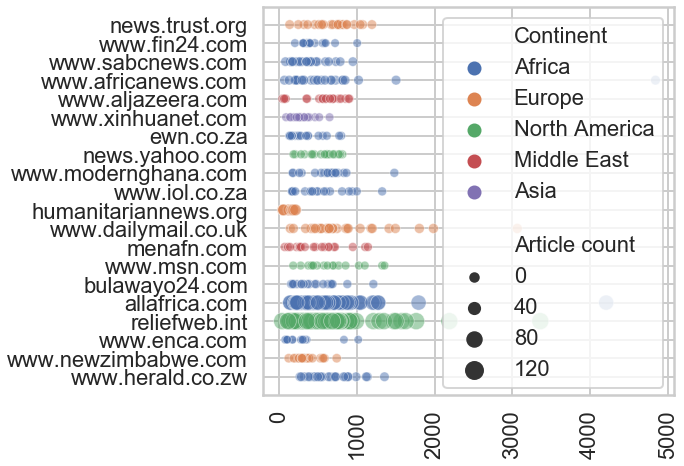

In [112]:
sns.set_context('poster')
fig, ax = plt.subplots(figsize=(10,7))
sns.scatterplot(x='words', y='url',
                hue='Continent', size='\nArticle count', alpha=.5, data=new_moza)
plt.xticks(rotation='vertical')
ax.set(xlabel=None, ylabel=None)
plt.legend()
plt.tight_layout()
plt.savefig('../plots/mozambique_urls.png')
plt.show()